In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [58]:
# 데이터 셋 불러오기

X_train_df_log = pd.read_csv("./data/X_train_df_log.csv")
X_test_df_log = pd.read_csv("./data/X_test_df_log.csv")
y_train_df_log = pd.read_csv("./data/y_train_df_log.csv")
test_df = pd.read_csv("./data/test_without_error.csv")
sub = pd.read_csv("./data/sample_submission.csv")

### Linear Regression Model Hyper parameter tuning with GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [60]:
# 선형회귀 모델 최적의 alpha 값 탐색

params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20]}

elastic_params = {"alpha": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                 "l1_ratio": [0.1, 0.3, 0.5, 0.7, 1]}


ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

grid_ridge = GridSearchCV(ridge, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_lasso = GridSearchCV(lasso, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_elastic = GridSearchCV(elastic, param_grid=elastic_params, cv=5, scoring="neg_mean_absolute_error")

grid_ridge.fit(X_train_df_log, y_train_df_log)
grid_lasso.fit(X_train_df_log, y_train_df_log)
grid_elastic.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 20],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_absolute_error')

In [61]:
grid_ridge.best_params_

{'alpha': 20}

### 랜덤포레스트 모델 및 선형회귀 모델 평가

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

rf_reg = RandomForestRegressor(n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

<ipython-input-62-1056bd463b06>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(X_train, y_train)


16.514482089963032

In [63]:
# 랜덤포레스트 이상치처리 및 다중공선성피처제거한 데이터셋으로 학습

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train_df_log, y_train_df_log)
pred = model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df.shape

<ipython-input-63-a2dad7adbd34>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_df_log, y_train_df_log)


(150, 2)

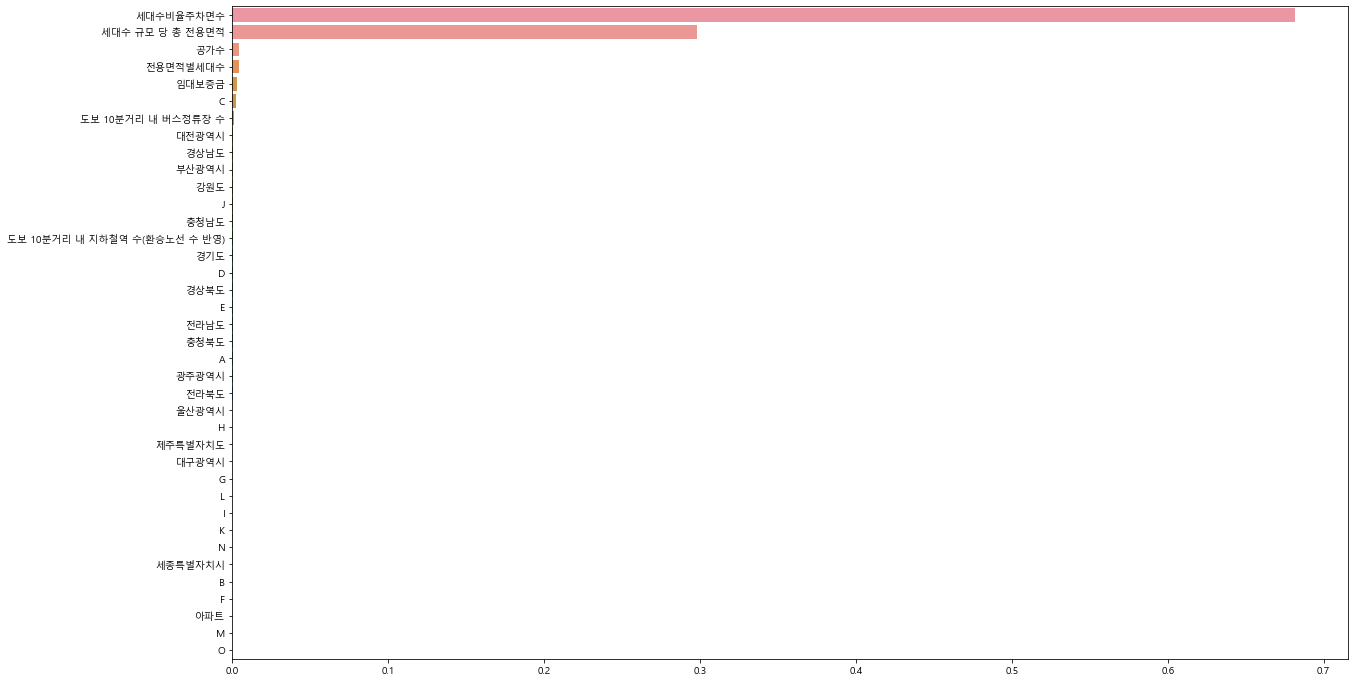

In [64]:
importance = model.feature_importances_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [65]:
# 라쏘 모델 예측 성능 평가

lasso_model = Lasso(alpha=0.01)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

lasso_model.fit(X_train, y_train)
pred = lasso_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

18.316002653360133

In [66]:
# 릿지 모델 예측 성능 평가

ridge_model = Ridge(alpha=20)
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25, random_state=42)

ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_test)


mean_absolute_error(np.expm1(y_test), np.expm1(pred))

16.52998250249498

In [67]:
ridge_model = Ridge(alpha=20)

ridge_model.fit(X_train_df_log, y_train_df_log)
pred = ridge_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df.shape

(150, 2)

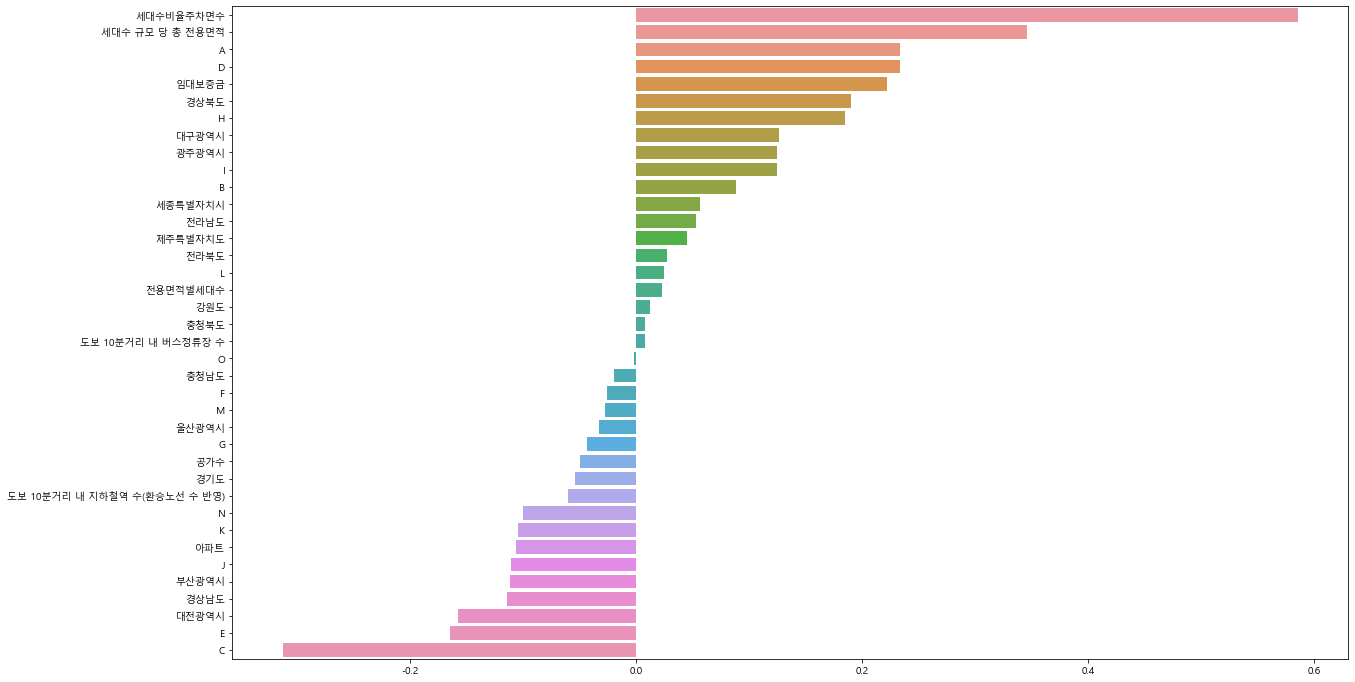

In [68]:
importance = ridge_model.coef_
feature_importance = pd.Series(data=importance[0], index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()